My first approach to this problem was to generate a histogram of the frequency outputs, and possible use a mixture of guassians model to represent their distribution. 

'Histogram of frequencies'

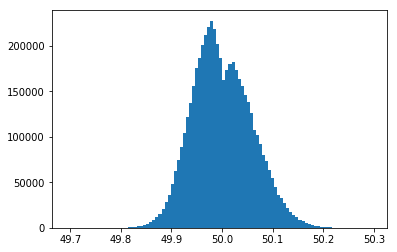

In [6]:
from numpy import genfromtxt, math
import matplotlib.pyplot as plt

frequency_variations = genfromtxt('upside/2015_2mo.csv', delimiter=',')

plt.hist(frequency_variations[2:-1,1], bins=100)

"Histogram of frequencies"

However, because I would need to take into account the state of the battery I opted instead to create a model of the system, and run it through the sample data.

To visualise this, I generated a plot of the frequency of the system under control, and the energy held by the battery as follows. Please forgive the messiness of the code in this snippet. The model itself should be reasonably easy to understand.

N.B. I got bizarre results when I used a self discharge rate of 100kWh, so I swapped it out to 10 kWh. This can be altered by changing the arguments sent to the battery. I also wouldn't normally use default arguments as I have here were it a real system as it would make it too easy to make an error when creating building the objects.

In [7]:

from numpy import genfromtxt, math
from datetime import datetime
import numpy as np

from upside.systemsimulation.Battery import Battery
from upside.systemsimulation.DFFRService import DFFRService

frequency_variations = genfromtxt('upside/2015_2mo.csv', delimiter=',')

battery = Battery()
service = DFFRService(battery=battery)

frequencyHistory = np.empty((0,2), int)
for record in frequency_variations:
    if math.isnan(record[0]):
        continue

    datetime = datetime.utcfromtimestamp(record[0])

    frequencyHistory = np.append(frequencyHistory, [[record[1],battery.energy_stored()]], axis=0)

    service.regulate_load(record[1], 1)

    if (datetime.day==2):
        break

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(frequencyHistory[:,0],'b')
ax1.set_ylabel('Frequency (Hz)')
ax2 = ax1.twinx()
ax2.plot(frequencyHistory[:,1],'r')
ax2.set_ylabel('Energy held in battery (MWh)')



To answer the question "The probability of being unable to run a contract continuously from midnight to 8am", I ran the model over the dataset, recording the number of days on which the system failed. I then give the probability from these data.

In [ ]:
isBetweenMidnightAndEight = False
continuouslyWorking = False

countOfSuccesses=0
countOfFails=0
for record in frequency_variations:
    if math.isnan(record[0]):
        continue
         
    datetime = datetime.utcfromtimestamp(record[0])
    loadRegulatedSuccessfully = service.regulate_load(record[1], 1)
    if datetime.hour == 0:
        isBetweenMidnightAndEight=True
        continuouslyWorking=True

    elif isBetweenMidnightAndEight:
        continuouslyWorking &= loadRegulatedSuccessfully
        
    if isBetweenMidnightAndEight & (datetime.hour == 9):
        if continuouslyWorking:
            countOfSuccesses+=1
        else:
            countOfFails+=1
        isBetweenMidnightAndEight=False
        
total = countOfSuccesses + countOfFails
probabilityOfFail = countOfFails/ total
print("The system could not provide an unbroken contract for %d of %d days, so the probability of it failing on a given day is is %.2f" % (countOfFails, total, probabilityOfFail))

The system could not provide an unbroken contract for 42 of 60 days, so the probability of it succeeding on a given day is is 0.70


In [ ]:
countOfSuccesses=0
total=0
for record in frequency_variations:
    if math.isnan(record[0]):
        continue
     
    if service.regulate_load(record[1], 1):
        countOfSuccesses+=1
    
    total+=1
        
pSuccessOnAGivenSecond = countOfSuccesses/total

print("Probability of a success in a given second is %.6f" % (pSuccessOnAGivenSecond))

Probability of a success in a given second is 0.952783


Assuming that the frequency measurements are independent, which is maybe an oversimplification, and that the probability of success can be modelled as X~B(n,p). The probability of fail after N trials is equivalent to probability of success for N trials.

X represents no. fails

P(X>=1) >= 0.2

1 - (P(X<1)) >= 0.2

1 - P(X=0) >= 0.2

1 - p(success)^N >= 0.2

0.8 >= p(success)^N

log(0.8) >= Nlog(p(success))

log(0.8(/log(p(success)) >= N

In [16]:
from math import log

n = log(0.2)/log(pSuccessOnAGivenSecond)

print("System should run for %d seconds before the probability of fail exceeds 20%%" % n)

System should run for 33 seconds before the probability of fail exceeds 20%
